<a href="https://colab.research.google.com/github/EloneSampaio/SkinVisionAI/blob/master/VitAndCnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classe Base

#### https://iqbalpa.medium.com/easily-image-data-preparation-with-imagedatagenerator-in-tensorflow-5fd75fb32bc2

#### https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

#### https://huggingface.co/google/vit-base-patch16-224

# Função para Carregar Imagens Organizadas em Pastas de Classes

### Uso do  mixed precision training (precisão mista) para operações em float16, que é mais rápida e consome menos memória.

### Ativar cuda pra GPU se estiver ativo

In [3]:
from tensorflow.keras.mixed_precision import set_global_policy
# Verifique se a GPU está ativa
import torch
is_cuda =  torch.cuda.is_available()
print("GPU is available?", is_cuda)

# Habilitar mixed precision
set_global_policy('mixed_float16')


GPU is available? True


### Ativar logs

In [4]:
import logging
# Configurar logs
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler("pipeline.log"), logging.StreamHandler()]
)

#Carregar as imagens

In [5]:
class BaseExtractor:
    def preprocess_images(self, images):
        raise NotImplementedError("Subclasses must implement this method.")

    def extract_features(self, images, labels=None):
        raise NotImplementedError("Subclasses must implement this method.")


# CNNFeatureExtractor

In [6]:
import tensorflow as tf
from google.colab import drive
import os
from PIL import Image
import numpy as np

class CNNFeatureExtractor(BaseExtractor):
    def __init__(self, model_name='VGG16', input_shape=(224, 224, 3), batch_size=32):
        self.model_name = model_name
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.model = self._load_model()

    def _load_model(self):
        if self.model_name == 'VGG16':
            return tf.keras.applications.VGG16(include_top=False, input_shape=self.input_shape, pooling='avg')
        elif self.model_name == 'ResNet50':
            return tf.keras.applications.ResNet50(include_top=False, input_shape=self.input_shape, pooling='avg')
        raise ValueError("Unsupported CNN model.")

    def preprocess_images(self, images):
        if self.model_name == 'VGG16':
            return tf.keras.applications.vgg16.preprocess_input(images)
        elif self.model_name == 'ResNet50':
            return tf.keras.applications.resnet50.preprocess_input(images)

    def extract_features(self, images, labels=None):

        processed_images = self.preprocess_images(images)
        features = self.model.predict(processed_images, verbose=1)
        return features


# ViTFeatureExtractor


In [7]:
from transformers import AutoImageProcessor, AutoModel, ViTImageProcessorFast,AutoFeatureExtractor
from transformers import AutoConfig



class ViTFeatureExtractor(BaseExtractor):
    def __init__(self, model_name='google/vit-base-patch16-224'):
        self.model_name = model_name
        if 'vit' in model_name:
              self.processor = ViTImageProcessorFast.from_pretrained(self.model_name, use_fast=True)
        elif 'deit' in model_name:
             self.processor = AutoFeatureExtractor.from_pretrained(self.model_name)
        else:
            pass
        self.config = AutoConfig.from_pretrained(self.model_name, torch_dtype=torch.float16) # https://huggingface.co/docs/transformers/v4.48.2/en/model_doc/auto#transformers.AutoConfig
        self.model = AutoModel.from_pretrained(self.model_name, config=self.config) #https://huggingface.co/docs/transformers/model_doc/auto



    def preprocess_images(self, images):
        return self.processor(images=images, return_tensors="pt")

    def extract_features(self, images):
          """
          Extrai características processando as imagens.
          Args:
              images (np.ndarray): Imagens para extração.
          Returns:
              np.ndarray: Características extraídas.
          """
          features = []

          inputs = self.preprocess_images(images)
          outputs = self.model(**inputs)
          if is_cuda:
            features = outputs.last_hidden_state[:, 0, :].detach().numpy()  # Token [CLS]
          else:
            features = outputs.last_hidden_state[:, 0, :].cpu().detach().numpy()  # Token [CLS]
          return features


# FeatureExtractorFactory

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
import cProfile
from joblib import Parallel, delayed
from collections import Counter
from tqdm.notebook import tqdm
import tensorflow as tf
import logging
import os
from PIL import Image

# Configuração de logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

class FeatureExtractorFactory:
    @staticmethod
    def create_extractor(model_name, input_shape=(224, 224, 3)):
        """
        Cria um extrator de características com base no nome do modelo.
        Args:
            model_name (str): Nome do modelo (ex: 'VGG16', 'ResNet50', 'vit').
            input_shape (tuple): Formato das imagens de entrada.
        Returns:
            Instância do extrator de características.
        """
        if model_name in ['VGG16', 'ResNet50', 'EfficientNetB0']:
            return CNNFeatureExtractor(model_name, input_shape)
        elif 'vit' in model_name or 'facebook':
            return ViTFeatureExtractor(model_name)
        else:
            raise ValueError(f"Model {model_name} is not supported.")

    @staticmethod
    def show_model_summary(model):
        """
        Exibe o resumo do modelo.
        Args:
            model: Instância do modelo.
        """
        return model.summary()

    @staticmethod
    def classes_balance(labels, criteria_value=5):
        """
        Verifica se as classes estão balanceadas.
        Args:
            labels (np.ndarray): Rótulos do dataset.
            criteria_value (float): Valor de proporção para considerar desbalanceamento.
        Returns:
            float: Razão entre a classe majoritária e minoritária.
        """
        class_counts = Counter(labels)
        logging.info(f"Distribuição das Classes: {class_counts}")
        print(f"Distribuição das Classes: {class_counts}")
        majority_class = max(class_counts.values())
        minority_class = min(class_counts.values())
        ratio = majority_class / minority_class
        print(f"Razão entre as classes: {ratio:.1f}:1")
        logging.info(f"Razão entre as classes: {ratio:.1f}:1")
        if ratio > criteria_value:
            print("O conjunto está desbalanceado")
            logging.info("O conjunto está desbalanceado")
        else:
            print("O conjunto está balanceado")
            logging.info("O conjunto está balanceado")
        return ratio

    @staticmethod
    def split_data(images, labels, test_size=0.2, random_state=42):
        """
        Divide o conjunto de dados em treinamento e teste.
        Args:
            images (np.ndarray): Imagens do dataset.
            labels (np.ndarray): Rótulos correspondentes.
            test_size (float): Proporção de dados para teste.
            random_state (int): Semente para reprodutibilidade.
        Returns:
            tuple: (X_train, X_test, y_train, y_test)
        """
        return train_test_split(images, labels, test_size=test_size, stratify=labels, random_state=random_state)

    @staticmethod
    def extractor_with_batch(batch_images, extractor):
        """
        Extrai características de um lote de imagens.
        Args:
            batch_images (np.ndarray): Lote de imagens.
            extractor (BaseExtractor): Instância do extrator.
        Returns:
            np.ndarray: Características extraídas.
        """
        if tf.config.list_physical_devices('GPU'):
            batch_images = tf.convert_to_tensor(batch_images)  # Garantir que está no formato Tensor
            features = extractor.extract_features(batch_images).numpy()
        else:
            features = extractor.extract_features(batch_images)
        return features

    @staticmethod
    def extract_and_save(extractor, images, labels=None, batch_size=32, file_name='features.npz', verbose=True):
        """
        Extrai características e salva em um arquivo .npz.
        Args:
            extractor (BaseExtractor): Instância do extrator.
            images (np.ndarray): Imagens para extração.
            labels (np.ndarray): Rótulos correspondentes (opcional).
            batch_size (int): Tamanho do lote para processamento.
            file_name (str): Nome do arquivo de saída.
            verbose (bool): Mostrar progresso.
        Returns:
            tuple: (features, labels)
        """
        try:
            use_gpu = len(tf.config.list_physical_devices('GPU')) > 0
            features_list = []

            if use_gpu:
                # Criar um Dataset do TensorFlow a partir das imagens
                dataset = tf.data.Dataset.from_tensor_slices(images)
                dataset = dataset.batch(batch_size)  # Dividir em lotes
                dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Melhorar eficiência carregando dados assincronamente

                if verbose:
                    print(f"Extraindo características de {len(images)} imagens na GPU...")

                # Percorrer os batches com barra de progresso
                for batch in tqdm(dataset, desc="Extraindo", disable=not verbose):
                    batch_features = FeatureExtractorFactory.extractor_with_batch(batch, extractor)
                    features_list.append(batch_features)
            else:
                # Dividir imagens em lotes
                batches = [images[i:i + batch_size] for i in range(0, len(images), batch_size)]

                # Processamento paralelo com barra de progresso
                features_list = Parallel(n_jobs=-1)(
                    delayed(FeatureExtractorFactory.extractor_with_batch)(batch, extractor)
                    for batch in tqdm(batches, desc="Extraindo", disable=not verbose)
                )

            # Concatenar todas as features
            features = np.vstack(features_list)

            # Salvar características
            if labels is not None:
                np.savez(file_name, features=features, labels=labels)
            else:
                np.savez(file_name, features=features)

            logging.info(f"✅ Características salvas em {file_name}")
            print(f"✅ Características salvas em {file_name}")

            return features, labels
        except Exception as e:
            logging.error(f"❌ Erro ao extrair características: {e}")
            print(f"❌ Erro ao extrair características: {e}")
            raise

    @staticmethod
    def load_images_with_labels(base_folder, image_size=(224, 224)):
        """
        Carrega imagens organizadas por classes em subpastas.
        Args:
            base_folder (str): Caminho para a pasta geral contendo subpastas de classes.
            image_size (tuple): Dimensão para redimensionar as imagens.
        Returns:
            tuple: (X, y, class_names)
        """
        try:
            images = []
            labels = []
            class_names = sorted(os.listdir(base_folder))  # Lista de classes (subpastas)

            for class_idx, class_name in enumerate(class_names):
                class_folder = os.path.join(base_folder, class_name)
                if os.path.isdir(class_folder):
                    for file_name in os.listdir(class_folder):
                        file_path = os.path.join(class_folder, file_name)
                        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')) and "_" not in file_name.lower():
                            try:
                                # Abrir e redimensionar a imagem
                                with Image.open(file_path) as img:
                                    img_resized = img.resize(image_size)
                                    img_array = np.array(img_resized)
                                    images.append(img_array)
                                    labels.append(class_idx)
                                print(f"Imagem {file_name} da classe '{class_name}' carregada com sucesso.")
                            except Exception as e:
                                print(f"Erro ao carregar a imagem {file_name}: {e}")

            return np.array(images), np.array(labels), class_names
        except Exception as e:
            logging.error(f"Erro ao carregar imagens: {e}")
            raise

#  Classe para avaliação de características extraídas

   **Resumo**
   
  Para avaliar a qualidade das características sem classificação:

  1. Visualize os dados no espaço reduzido: Use PCA ou t-SNE.
  2. Analise variância e entropia: Verifique a diversidade nas características.
  3. Calcule distâncias intra/inter-classes: Garanta que os dados estão bem separados.
  4. Cheque correlações: Identifique redundâncias.
  5. Interprete mapas de ativação: Para entender o que o modelo está aprendendo.

# Funcionalidades
1. Visualizações: PCA e t-SNE para entender a separação no espaço das características.
2. Métricas Estatísticas: Variância e entropia para medir a diversidade das características.
3. Distâncias: Mede a separação intra e inter-classe.
4. Correlação: Identifica redundâncias entre características.
5. Relatório Consolidado: Um resumo completo das métricas e visualizações.
A classe permite uma análise robusta e completa da qualidade das características extraídas.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import entropy
from scipy.spatial.distance import cdist
import seaborn as sns
import os

class FeatureEvaluator:
    def __init__(self, features, labels, output_dir="results"):
        """
        Inicializa a classe de avaliação com as características e os rótulos.
        Args:
            features (np.ndarray): Características extraídas (forma: [n_samples, n_features]).
            labels (np.ndarray): Rótulos correspondentes às características.
            output_dir (str): Diretório para salvar os resultados.
        """
        self.features = features
        self.labels = labels
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        self.entropies = None
        self.variances = None
        self.J = None
        self.inter_dist = None
        self.intra_dist = None
        self.inter_variance = None
        self.intra_variance = None


    def visualize_pca(self, n_components=2):
        """
        Visualiza as características reduzidas com PCA.
        Args:
            n_components (int): Número de componentes a reduzir (default: 2).
        """
        pca = PCA(n_components=n_components)
        reduced_features = pca.fit_transform(self.features)
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=self.labels, cmap='viridis', alpha=0.7)
        plt.title('PCA das Características')
        plt.colorbar(label="Classe")
        #plt.show()
        output_path = os.path.join(self.output_dir, "pca_visualization.png")
        plt.savefig(output_path)
        logging.info(f"PCA visualization saved to {self.output_dir}")
        # return image full folder and name
        print(f"PCA visualization saved to {output_path}")
        return output_path

    def visualize_tsne(self, n_components=2, perplexity=30, random_state=42):
        """
        Visualiza as características reduzidas com t-SNE.
        Args:
            n_components (int): Número de componentes a reduzir (default: 2).
            perplexity (int): Perplexidade para o t-SNE (default: 30).
            random_state (int): Semente para reprodutibilidade (default: 42).
        """
        tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
        reduced_features = tsne.fit_transform(self.features)
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=self.labels, cmap='viridis', alpha=0.7)
        plt.title('t-SNE das Características')
        plt.colorbar(label="Classe")
        output_path = os.path.join(self.output_dir, "tsne_visualization.png")
        plt.savefig(output_path)
        logging.info(f"t-SNE visualization saved to {output_path}")
        #plt.show()
        return output_path


    def calculate_variance(self):
        """
        Calcula a variância de cada característica.
        Returns:
            np.ndarray: Variâncias das características.
        """
        variances = np.mean(np.var(self.features, axis=0))
        print(f"Variância média das características: {variances:.4f}")
        return variances

    def calculate_entropy(self):
        """
        Calcula a entropia de cada característica.
        Returns:
            np.ndarray: Entropias das características.
        """
        feature_entropies = np.mean([entropy(np.histogram(f, bins=10, density=True)[0]) for f in self.features.T])
        print(f"Entropia média das características: {np.mean(feature_entropies):.4f}")
        return feature_entropies

    def calculate_variance_inter_and_intra_and_separability(self):
      """
      Calcula as variâncias médias intra-classe e inter-classe.
      Returns:
        tuple: Variância média intra-classe e inter-classe.
      """
      intra_class_variance = []
      class_centroids = {}

      # Calcular variância intra-classe e guardar os centroides
      for class_label in np.unique(self.labels):
          # Filtrar as características da classe atual
          class_features = self.features[self.labels == class_label]

          # Variância intra-classe
          intra_variance = np.var(class_features, axis=0)
          intra_class_variance.append(np.mean(intra_variance))

          # Centroide da classe
          class_centroids[class_label] = np.mean(class_features, axis=0)

      # Calcular variância inter-classe com os centroides
      centroids = np.array(list(class_centroids.values()))
      centroid_variance = np.var(centroids, axis=0)
      variance_inter_mean = np.mean(centroid_variance)

      # Variância intra-classe média
      variance_intra_mean = np.mean(intra_class_variance)
      # Índice de separabilidade
      separability = variance_inter_mean / variance_intra_mean

      print(f"Variância média intra-classe: {variance_intra_mean:.4f}")
      print(f"Variância média inter-classe: {variance_inter_mean:.4f}")
      print(f"Índice de separabilidade: {separability:.4f}")
      return variance_intra_mean, variance_inter_mean,separability


    def calculate_distances(self):
        """
        Calcula as distâncias médias intra-classe e inter-classe.
        Returns:
            tuple: Distância média intra-classe, distância média inter-classe.
        """
        intra_class_dists = []
        inter_class_dists = []

        for class_label in np.unique(self.labels):
            # Distâncias intra-classe
            class_features = self.features[self.labels == class_label]
            intra_dists = cdist(class_features, class_features, metric='euclidean')
            intra_class_dists.append(np.mean(intra_dists))

            # Distâncias inter-classe
            other_features = self.features[self.labels != class_label]
            inter_dists = cdist(class_features, other_features, metric='euclidean')
            inter_class_dists.append(np.mean(inter_dists))

        intra_mean = np.mean(intra_class_dists)
        inter_mean = np.mean(inter_class_dists)
        print(f"Distância média intra-classe: {intra_mean:.4f}")
        print(f"Distância média inter-classe: {inter_mean:.4f}")
        return intra_mean, inter_mean

    def visualize_correlations(self):
        """
        Visualiza a matriz de correlação entre as características.
        """
        correlation_matrix = np.corrcoef(self.features, rowvar=False)
        sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
        plt.title('Matriz de Correlação entre Características')
        #plt.show()
        output_path = os.path.join(self.output_dir, "correlations_visualization.png")
        plt.savefig(output_path)
        logging.info(f"Correlations visualization saved to {output_path}")
        return output_path

    def generate_report(self):
        """
        Gera um relatório com todas as métricas e visualizações.
        """
        print("=== Relatório de Avaliação das Características ===")
        print("1. Variância das Características:")
        self.variances = self.calculate_variance()
        print("2. Entropia das Características:")
        self.entropies = self.calculate_entropy()
        print("3. Distâncias Intra e Inter-Classe:")
        self.intra_dist, self.inter_dist = self.calculate_distances()
        print("4. Variância Média Intra-Classe , Inter-Classe e Separabilidade:")
        self.intra_variance, self.inter_variance,self.J = self.calculate_variance_inter_and_intra_and_separability()
        print("5. Matriz de Correlação:")
        #self.visualize_correlations()
        print("6. Visualizações:")
        #self.visualize_pca()
        #self.visualize_tsne()

        report_path = os.path.join(self.output_dir, "evaluation_report.txt")
        with open(report_path, "w") as report:
            report.write("=== Relatório de Avaliação ===\n")
            report.write(f"Média da Variância: {self.variances}\n")
            report.write(f"Média da Entropia: {self.entropies}\n")
            report.write(f"Distância Média Intra-Classe: {self.intra_dist}\n")
            report.write(f"Distância Média Inter-Classe: {self.inter_dist}\n")
            report.write(f"Variância Média Intra-Classe: {self.intra_variance}\n")
            report.write(f"Variância Média Inter-Classe: {self.inter_variance}\n")
            report.write(f"Índice de Separabilidade(J): {self.J}\n")
        logging.info(f"Evaluation report saved to {report_path}")
        return report_path


    def generate_pdf_report(self):
        pdf = PDFReport()
        pdf.add_title("Relatório de Avaliação de Características")
        # Adicionar texto do relatório
        report_text = "=== Relatório de Avaliação ===\n"

        report_text += f"Média da Variância: {self.variances}\n"
        report_text += f"Média da Entropia: {self.entropies}\n"
        report_text += f"Distância Média Intra-Classe: {self.intra_dist}\n"
        report_text += f"Distância Média Inter-Classe: {self.inter_dist}\n"
        report_text += f"Variância Média Intra-Classe: {self.intra_variance}\n"
        report_text += f"Variância Média Inter-Classe: {self.inter_variance}\n"
        report_text += f"Índice de Separabilidade(J): {self.J}\n"
        pdf.add_text(report_text)

        # Adicionar visualizações
        pca_path = self.visualize_pca()
        tsne_path = self.visualize_tsne()
        correlations_path = self.visualize_correlations()
        print(f"PCA visualization saved to {pca_path}")
        print(f"t-SNE visualization saved to {tsne_path}")
        print(f"Correlations visualization saved to {correlations_path}")

        pdf.add_image(tsne_path)
        pdf.add_image(correlations_path)
        pdf.add_image(pca_path)

        # Salvar PDF
        pdf_output_path = os.path.join(self.output_dir, "evaluation_report.pdf")
        pdf.output(pdf_output_path)
        logging.info(f"PDF report saved to {pdf_output_path}")





# PDFReport

In [10]:
!pip install fpdf

In [11]:
from fpdf import FPDF

class PDFReport(FPDF):
    def __init__(self):
        super().__init__()
        self.set_auto_page_break(auto=True, margin=15)
        self.add_page()
        self.set_font('Arial', size=12)

    def add_title(self, title):
        self.set_font('Arial', style='B', size=16)
        self.cell(200, 10, txt=title, ln=True, align='C')
        self.ln(10)

    def add_text(self, text):
        self.set_font('Arial', size=12)
        self.multi_cell(0, 10, text)
        self.ln(5)

    def add_image(self, image_path, x=None, y=None, w=180):
        self.image(image_path, x=x, y=y, w=w)
        self.ln(10)

# Classe DataProcessor
Classe que encapsula funcionalidades como:
  1. Data Augmentation
  2. Balanceamento de Classes,
  3. Normalização e Pré-Processamento
  4. Redução de Dimensionalidade.

In [12]:
!pip install tensorflow

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator




import numpy as np

class DataProcessor:
    def __init__(self):
        """
        Inicializa o processador de dados com configurações padrão.
        """
        self.scaler = StandardScaler()
        self.balance_method = None
        self.pca = None

    def augment_data(self, X, y, batch_size=32, desired_samples=500,augmentation_config=None, num_batches=None):
        """
        Realiza data augmentation em imagens, com opção de gerar todos os dados.
        Args:
            X (np.ndarray): Imagens em formato NumPy.
            y (np.ndarray): Rótulos correspondentes.
            batch_size (int): Tamanho do lote para augmentação.
            desired_samples (int): Número total de amostras desejado.
            augmentation_config (dict): Configurações para o ImageDataGenerator.
            num_batches (int): Número de lotes a serem gerados. Se None, itera até o fim dos dados.

        Returns:
            tuple: Imagens aumentadas (np.ndarray) e rótulos (np.ndarray).
        """
        if augmentation_config is None:
            augmentation_config = {
                "rotation_range": 20,
                "width_shift_range": 0.2,
                "height_shift_range": 0.2,
                "horizontal_flip": True,
                "brightness_range": [0.8, 1.2],
                "zoom_range": 0.2,
                "shear_range": 0.2,
                "channel_shift_range": 20.0,
                "fill_mode": "nearest"
            }

        # Configurar o gerador
        datagen = ImageDataGenerator(**augmentation_config)
        augmented_data = datagen.flow(X, y, batch_size=batch_size)
        print(f"Data augmentation configurado com batch size {batch_size}.")

        # Gerar e armazenar todos os lotes
        X_augmented = []
        y_augmented = []


        if num_batches is None:
            # Calcular o número total de lotes para cobrir todos os dados
            num_batches = len(X) // batch_size + (len(X) % batch_size != 0)

        for _ in range(desired_samples // batch_size):
            X_batch, y_batch = next(augmented_data)
            X_augmented.append(X_batch)
            y_augmented.append(y_batch)

        # Concatenar todos os lotes em arrays únicos
        X_augmented = np.concatenate(X_augmented, axis=0)
        y_augmented = np.concatenate(y_augmented, axis=0)

        return X_augmented, y_augmented


    def balance_classes(self, X, y):
        """
        Realiza o balançamento escolhido(SMOTE,RandomOverSampler,RandomUnderSampler) para balancear as classes.
        https://medium.com/analytics-vidhya/handling-imbalanced-data-by-oversampling-with-smote-and-its-variants-23a4bf188eaf
        Args:
            X (np.ndarray): Características ou imagens.
            y (np.ndarray): Rótulos correspondentes.
        Returns:
            tuple: (X_resampled, y_resampled)
        """
        if self.balance_method == "SMOTE":
            smote = SMOTE(random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X.reshape(len(X), -1), y)
        elif self.balance_method == "RandomOverSampler":
            ros = RandomOverSampler(random_state=42)
            X_resampled, y_resampled = ros.fit_resample(X.reshape(len(X), -1), y)
        elif self.balance_method == "RandomUnderSampler":
            rus = RandomUnderSampler(random_state=42)
            X_resampled, y_resampled =  rus.fit_resample(X.reshape( len(X), -1), y)
        else:
            X_resampled = X
            y_resampled = y
            print("Sem balanceamento")
        print(f"Dados balanceados: {np.bincount(y_resampled)}")
        return X_resampled.reshape(-1, *X.shape[1:]), y_resampled

    def normalize_features(self, X):
        """
        Normaliza as características para zero-mean e unit-variance.
        Aceita dados em 2D ou 4D (imagens).
        Args:
            X (np.ndarray): Características extraídas ou imagens.
        Returns:
            np.ndarray: Características normalizadas.
        """
        if len(X.shape) == 4:  # Imagens no formato [n_samples, height, width, channels]
            original_shape = X.shape
            X = X.reshape(X.shape[0], -1)  # Achatar para [n_samples, n_features]

        X_normalized = self.scaler.fit_transform(X)  # Normalização

        if len(original_shape) == 4:
            X_normalized = X_normalized.reshape(original_shape)  # Voltar ao formato original

        print("Características normalizadas (zero-mean, unit-variance).")
        return X_normalized


    def reduce_dimensionality(self, X, variance_threshold=0.95):
        """
        Reduz a dimensionalidade das características usando PCA.
        Args:
            X (np.ndarray): Características extraídas.
            variance_threshold (float): Porcentagem da variância a ser retida.
        Returns:
            np.ndarray: Características reduzidas.
        """
        self.pca = PCA(n_components=variance_threshold)
        X_reduced = self.pca.fit_transform(X)
        print(f"Redução de dimensionalidade concluída: {X_reduced.shape[1]} componentes retidos.")
        return X_reduced

    def inverse_transform_pca(self, X_reduced):
        """
        Reconstrói características reduzidas ao espaço original.
        Args:
            X_reduced (np.ndarray): Características reduzidas.
        Returns:
            np.ndarray: Características no espaço original.
        """
        if self.pca is None:
            raise ValueError("PCA não foi aplicado anteriormente.")
        return self.pca.inverse_transform(X_reduced)


# Classe AugmentationOptimizer

1. Recebe os dados, rótulos e o modelo.
2. Usa Optuna para explorar os melhores hiperparâmetros do ImageDataGenerator

## Método optimize:

1. Define o espaço de busca para parâmetros como:
- rotation_range
- width_shift_range
- height_shift_range
- brightness_range

Simula o treinamento e avalia o impacto dos hiperparâmetros na performance do modelo.

In [14]:
!pip install optuna

In [15]:
import optuna


class AugmentationOptimizer:
    def __init__(self, extractor, data, labels, batch_size=32, output_dir="results"):
        self.extractor = extractor  # Instância do extrator de características
        self.data = data
        self.labels = labels
        self.output_dir = output_dir
        self.batch_size = batch_size
        os.makedirs(output_dir, exist_ok=True)

    def optimize(self, n_trials=20):
        def objective(trial):
            # Espaço de busca dos hiperparâmetros
            rotation_range = trial.suggest_int("rotation_range", 0, 45)
            width_shift_range = trial.suggest_uniform("width_shift_range", 0.0, 0.2)
            height_shift_range = trial.suggest_uniform("height_shift_range", 0.0, 0.2)
            brightness_range_min = trial.suggest_uniform("brightness_range_min", 0.8, 1.2)
            brightness_range_max = 1.2
            zoom_range = trial.suggest_uniform("zoom_range", 0.2, 1.2)
            shear_range = trial.suggest_uniform("shear", 0.0, 0.2)
            channel_shift_range = trial.suggest_uniform("channel_shift_range", 20.0, 22.2)
            horizontal_flip = trial.suggest_categorical("horizontal_flip", [True, False])
            fill_mode = trial.suggest_categorical("fill_mode", ["nearest", "reflect", "wrap"])

            # Configuração do Data Augmentation
            datagen = ImageDataGenerator(
                rotation_range=rotation_range,
                width_shift_range=width_shift_range,
                height_shift_range=height_shift_range,
                brightness_range=[brightness_range_min, brightness_range_max],
                zoom_range = zoom_range,
                shear_range = shear_range,
                channel_shift_range = channel_shift_range,
                horizontal_flip=horizontal_flip,
                fill_mode= fill_mode

            )

            # Gerar dados aumentados
            augmented_data = datagen.flow(self.data, self.labels, batch_size=self.batch_size, shuffle=False)
            augmented_images, augmented_labels = self._collect_augmented_data(augmented_data)

            # Extração de características
            features = self.extractor.extract_features(augmented_images)

            # Avaliação da qualidade das características
            score = self.evaluate_features(features, augmented_labels)
            return score

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)

        best_params = study.best_params
        logging.info(f"Melhores hiperparâmetros: {best_params}")
        return best_params

    def _collect_augmented_data(self, datagen):
        augmented_images = []
        augmented_labels = []
        for batch_images, batch_labels in datagen:
            augmented_images.append(batch_images)
            augmented_labels.append(batch_labels)
            if len(augmented_images) * datagen.batch_size >= len(self.data):
                break
        return np.vstack(augmented_images)[:len(self.data)], np.hstack(augmented_labels)[:len(self.data)]

    def evaluate_features(self, features, labels):
        """
        Avalia a qualidade das características com base na separabilidade intra e inter-classe.
        """
        intra_class_variance = []
        inter_class_centroids = []

        for class_label in np.unique(labels):
            class_features = features[labels == class_label]
            intra_class_variance.append(np.var(class_features, axis=0))
            inter_class_centroids.append(np.mean(class_features, axis=0))

        inter_class_variance = np.var(inter_class_centroids, axis=0)
        separability = np.mean(inter_class_variance) / np.mean(intra_class_variance)

        logging.info(f"Separabilidade calculada: {separability:.4f}")
        return separability

# Classe DataPipeline

a classe  pipeline é estruturada para que cada etapa seja aplicada sequencialmente, com avaliações das métricas de separabilidade após cada transformação.

In [16]:
import numpy as np


class DataPipeline:
    '''
    Args:
       processor: Instância da classe DataProcessor
    '''
    def __init__(self, processor):
          self.processor = processor

    def run_pipeline(self, X, y, batch_size,desired_samples,augment_images=False, reduce_dimensionality= False, augmentation_config=None):
        """
        Executa o pipeline completo para melhorar as métricas de separabilidade.

        Args:
            X (np.ndarray): Características ou imagens originais.
            y (np.ndarray): Rótulos correspondentes.
            batch_size (int): Tamanho do lote para aumento de dados.
            desired_samples (int): Número total de amostras desejado.
            augment_images (bool): Indica se data augmentation será aplicada.
            augmentation_config (dict): Configurações para data augmentation (se aplicável).

        Returns:
            tuple: Características processadas, rótulos e métricas calculadas.
        """
        print("Iniciando pipeline de processamento de dados...")
        logging.info("Iniciando pipeline de processamento de dados...")

        # 1. Balancear classes
        print("\n== Etapa 1: Balanceamento de classes == e Shape =")
        X_balanced, y_balanced = self.processor.balance_classes(X, y)
        print(f"Dados balanceados Shape: {np.shape(X_balanced)}") # formato retornado: [n_samples, height, width, channels]
        logging.info(f"Dados balanceados Shape: {np.shape(X_balanced)}")

        # 2. Normalizar características
        print("\n== Etapa 2: Normalização de características ==")
        X_normalized = self.processor.normalize_features(X_balanced)

        # 3. Aumentar dados (se imagens)
        if augment_images:
            print("\n== Etapa 3: Data augmentation ==")
            logging.info("\n== Etapa 3: Data augmentation ==")
            X_augmented, y_augmented = self.processor.augment_data(
                X_balanced, y_balanced,batch_size, desired_samples, augmentation_config=augmentation_config
            )
            #X_augmented, y_augmented = next(augmented_data)  # Pega um lote de dados aumentados
            print(f"Dados aumentados Shape: {np.shape(X_augmented)}")
            logging.info(f"Dados aumentados Shape: {np.shape(X_augmented)}")
        else:
            X_augmented, y_augmented = X_normalized, y_balanced
            print(f"Dados não aumentados Shape: {np.shape(X_augmented)}")
            logging.info(f"Dados não aumentados Shape: {np.shape(X_augmented)}")

        # 4. Reduzir dimensionalidade
        if reduce_dimensionality:
            print("\n== Etapa 4: Redução de dimensionalidade ==")
            logging.info("\n== Etapa 4: Redução de dimensionalidade ==")
            X_reduced = self.processor.reduce_dimensionality(X_augmented, variance_threshold=0.95)
        else:
            X_reduced = X_augmented

        return X_reduced, y_augmented


# Ferramentas para Extração e Processamento de Características(PT)


Este repositório fornece uma estrutura modular para extrair, processar e avaliar características de imagens, utilizando modelos pré-treinados como CNNs (e.g., VGG16, ResNet) e Vision Transformers (ViTs). Inclui:

1. **FeatureExtractorFactory**: Uma fábrica para criar e gerenciar extratores de características.
2. **DataProcessor**: Uma classe utilitária para pré-processamento, aumento de dados, balanceamento e redução de dimensionalidade.
3. **FeatureEvaluator**: Uma ferramenta para analisar e avaliar a qualidade das características extraídas.

---

## **Visão Geral das Classes**

### **1. FeatureExtractorFactory**
Esta classe lida com:
- Carregamento de imagens organizadas em pastas de classes.
- Divisão de dados em conjuntos de treinamento e teste.
- Gerenciamento de extração de características com modelos pré-treinados.

#### **Métodos**
- `create_extractor(model_name, input_shape=(224, 224, 3))`
  - **Descrição**: Cria um extrator de características para um modelo especificado (CNN ou ViT).
  - **Args**:
    - `model_name (str)`: Nome do modelo pré-treinado (e.g., `VGG16`, `google/vit-base-patch16-224`).
    - `input_shape (tuple)`: Dimensões de entrada para o modelo (padrão: `(224, 224, 3)`).
  - **Retorna**: Instância de um extrator de características (CNN ou ViT).

- `load_images_with_labels(base_folder, image_size=(224, 224))`
  - **Descrição**: Carrega imagens e seus respectivos rótulos de uma pasta estruturada por subpastas de classe.
  - **Args**:
    - `base_folder (str)`: Caminho para a pasta principal contendo as subpastas de classes.
    - `image_size (tuple)`: Tamanho para redimensionar imagens (padrão: `(224, 224)`).
  - **Retorna**: Tupla `(X, y, class_names)` onde `X` é o array de imagens, `y` são os rótulos e `class_names` são os nomes das classes.

- `split_data(images, labels, test_size=0.2, random_state=42)`
  - **Descrição**: Divide o conjunto de dados em treinamento e teste.
  - **Args**:
    - `images (np.ndarray)`: Conjunto de imagens.
    - `labels (np.ndarray)`: Rótulos correspondentes.
    - `test_size (float)`: Proporção de dados para teste (padrão: `0.2`).
    - `random_state (int)`: Semente para reprodutibilidade (padrão: `42`).
  - **Retorna**: Tupla `(X_train, X_test, y_train, y_test)`.

- `extract_and_save(extractor, images, labels=None, file_name='features.npz')`
  - **Descrição**: Extrai características usando o extrator fornecido e as salva em um arquivo `.npz`.
  - **Args**:
    - `extractor (BaseExtractor)`: Uma instância do extrator de características.
    - `images (np.ndarray)`: Imagens para extração de características.
    - `labels (np.ndarray)`: Rótulos correspondentes (opcional).
    - `file_name (str)`: Nome do arquivo de saída (padrão: `features.npz`).
  - **Retorna**: Características extraídas como um array NumPy.

---

### **2. DataProcessor**
Esta classe fornece utilitários para pré-processamento de dados, aumento de dados, balanceamento, normalização e redução de dimensionalidade.

#### **Métodos**
- `augment_data(X, y, batch_size=32, augmentation_config=None)`
  - **Descrição**: Aplica aumento de dados ao dataset.
  - **Args**:
    - `X (np.ndarray)`: Dados de imagem.
    - `y (np.ndarray)`: Rótulos correspondentes.
    - `batch_size (int)`: Tamanho do lote para aumento (padrão: `32`).
    - `augmentation_config (dict)`: Configurações para o ImageDataGenerator (padrão: rotação, flip, brilho).
  - **Retorna**: Gerador de dados com imagens aumentadas.

- `balance_classes(X, y)`
  - **Descrição**: Balanceia o conjunto de dados realizando oversampling em classes minoritárias.
  - **Args**:
    - `X (np.ndarray)`: Dados de imagem ou características.
    - `y (np.ndarray)`: Rótulos correspondentes.
  - **Retorna**: Dados balanceados `(X_resampled, y_resampled)`.

- `normalize_features(X)`
  - **Descrição**: Normaliza as características para média zero e variância unitária.
  - **Args**:
    - `X (np.ndarray)`: Dados de características.
  - **Retorna**: Características normalizadas.

- `reduce_dimensionality(X, variance_threshold=0.95)`
  - **Descrição**: Reduz a dimensionalidade das características usando PCA.
  - **Args**:
    - `X (np.ndarray)`: Dados de características.
    - `variance_threshold (float)`: Porcentagem da variância a ser retida (padrão: `0.95`).
  - **Retorna**: Conjunto reduzido de características.

---

### **3. FeatureEvaluator**
Esta classe avalia a qualidade das características extraídas usando métricas e visualizações.

#### **Métodos**
- `visualize_pca(n_components=2)`
  - **Descrição**: Visualiza características em 2D usando PCA.

- `visualize_tsne(n_components=2, perplexity=30)`
  - **Descrição**: Visualiza características em 2D usando t-SNE.

- `calculate_variance()`
  - **Descrição**: Calcula a variância de cada característica.

- `calculate_entropy()`
  - **Descrição**: Calcula a entropia de cada característica.

- `calculate_distances()`
  - **Descrição**: Calcula distâncias intra e inter-classe.

- `visualize_correlations()`
  - **Descrição**: Exibe um heatmap de correlações entre características.

- `generate_report()`
  - **Descrição**: Gera um relatório abrangente de avaliação com métricas e visualizações.

---

## **Exemplo End-to-End**

```python
# Etapa 1: Carregar imagens do Google Drive
factory = FeatureExtractorFactory()
data_processor = DataProcessor()
base_folder = '/content/drive/My Drive/Imagens'
X, y, class_names = factory.load_images_with_labels(base_folder)

# Etapa 2: Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = factory.split_data(X, y)

# Etapa 3: Aplicar aumento de dados (opcional)
augmented_data = data_processor.augment_data(X_train, y_train)

# Etapa 4: Balancear classes no conjunto de treino
X_train_balanced, y_train_balanced = data_processor.balance_classes(X_train, y_train)

# Etapa 5: Extrair características usando VGG16
extractor = factory.create_extractor('VGG16')
features_train = factory.extract_and_save(extractor, X_train_balanced, y_train_balanced, 'train_features.npz')
features_test = factory.extract_and_save(extractor, X_test, y_test, 'test_features.npz')

# Etapa 6: Normalizar e reduzir dimensionalidade
features_train_normalized = data_processor.normalize_features(features_train)
features_train_reduced = data_processor.reduce_dimensionality(features_train_normalized)

# Etapa 7: Avaliar características
from evaluator import FeatureEvaluator
evaluator = FeatureEvaluator(features_train_reduced, y_train_balanced)
evaluator.generate_report()
```

---

## **Dependências**
- `tensorflow`
- `numpy`
- `scikit-learn`
- `matplotlib`
- `seaborn`
- `Pillow`
- `imblearn`

Instale as dependências com:
```bash
pip install tensorflow numpy scikit-learn matplotlib seaborn Pillow imbalanced-learn
```

---

## **Estrutura de Pastas**
```plaintext
root/
├── feature_extraction.py      # Contém FeatureExtractorFactory
├── data_processor.py          # Contém DataProcessor
├── feature_evaluator.py       # Contém FeatureEvaluator
├── examples/                  # Exemplos de uso das classes
└── README.md                  # Documentação
```

---

## **Melhorias Futuras**
1. Adicionar suporte para modelos pré-treinados adicionais (e.g., Swin Transformers).
2. Implementar mais técnicas de redução de dimensionalidade (e.g., t-SVD).
3. Integrar com armazenamento em nuvem para datasets em larga escala.

---

## **Contribuidores**
[Elone Izata Sampaio] - Desenvolvimento Inicial

---

## **Licença**
Este projeto está licenciado sob a Licença MIT. Consulte `LICENSE` para mais detalhes.



# Feature Extraction and Processing Toolkit(EN)



This repository provides a modular framework for extracting, processing, and evaluating features from images, leveraging pre-trained models such as CNNs (e.g., VGG16, ResNet) and Vision Transformers (ViTs). It includes:

1. **FeatureExtractorFactory**: A factory to create and manage feature extractors.
2. **DataProcessor**: A utility class for data preprocessing, augmentation, balancing, and dimensionality reduction.
3. **FeatureEvaluator**: A tool for analyzing and evaluating the quality of extracted features.

---

## **Classes Overview**

### **1. FeatureExtractorFactory**
This class handles:
- Loading images organized in class folders.
- Splitting data into training and testing sets.
- Managing feature extraction with pre-trained models.

#### **Methods**
- `create_extractor(model_name, input_shape=(224, 224, 3))`
  - **Description**: Creates a feature extractor for a specified model (CNN or ViT).
  - **Args**:
    - `model_name (str)`: Name of the pre-trained model (e.g., `VGG16`, `google/vit-base-patch16-224`).
    - `input_shape (tuple)`: Input dimensions for the model (default: `(224, 224, 3)`).
  - **Returns**: Instance of a feature extractor (CNN or ViT).

- `load_images_with_labels(base_folder, image_size=(224, 224))`
  - **Description**: Loads images and their corresponding labels from a folder structured by class subfolders.
  - **Args**:
    - `base_folder (str)`: Path to the main folder containing class subfolders.
    - `image_size (tuple)`: Size to resize images (default: `(224, 224)`).
  - **Returns**: Tuple `(X, y, class_names)` where `X` is the image array, `y` are labels, and `class_names` are the class names.

- `split_data(images, labels, test_size=0.2, random_state=42)`
  - **Description**: Splits the dataset into training and testing sets.
  - **Args**:
    - `images (np.ndarray)`: Image dataset.
    - `labels (np.ndarray)`: Corresponding labels.
    - `test_size (float)`: Proportion of data for testing (default: `0.2`).
    - `random_state (int)`: Seed for reproducibility (default: `42`).
  - **Returns**: Tuple `(X_train, X_test, y_train, y_test)`.

- `extract_and_save(extractor, images, labels=None, file_name='features.npz')`
  - **Description**: Extracts features using the provided extractor and saves them to a `.npz` file.
  - **Args**:
    - `extractor (BaseExtractor)`: An instance of the feature extractor.
    - `images (np.ndarray)`: Images for feature extraction.
    - `labels (np.ndarray)`: Corresponding labels (optional).
    - `file_name (str)`: Output file name (default: `features.npz`).
  - **Returns**: Extracted features as a NumPy array.

---

### **2. DataProcessor**
This class provides utilities for data preprocessing, augmentation, balancing, normalization, and dimensionality reduction.

#### **Methods**
- `augment_data(X, y, batch_size=32, augmentation_config=None)`
  - **Description**: Applies data augmentation to the dataset.
  - **Args**:
    - `X (np.ndarray)`: Image data.
    - `y (np.ndarray)`: Corresponding labels.
    - `batch_size (int)`: Batch size for augmentation (default: `32`).
    - `augmentation_config (dict)`: Configuration for augmentation (default: rotation, flip, brightness).
  - **Returns**: Data generator with augmented images.

- `balance_classes(X, y)`
  - **Description**: Balances the dataset by oversampling minority classes.
  - **Args**:
    - `X (np.ndarray)`: Image or feature data.
    - `y (np.ndarray)`: Corresponding labels.
  - **Returns**: Balanced data `(X_resampled, y_resampled)`.

- `normalize_features(X)`
  - **Description**: Normalizes features to zero mean and unit variance.
  - **Args**:
    - `X (np.ndarray)`: Feature data.
  - **Returns**: Normalized features.

- `reduce_dimensionality(X, variance_threshold=0.95)`
  - **Description**: Reduces the dimensionality of features using PCA.
  - **Args**:
    - `X (np.ndarray)`: Feature data.
    - `variance_threshold (float)`: Retained variance threshold (default: `0.95`).
  - **Returns**: Reduced feature set.

---

### **3. FeatureEvaluator**
This class evaluates the quality of extracted features using metrics and visualizations.

#### **Methods**
- `visualize_pca(n_components=2)`
  - **Description**: Visualizes features in 2D using PCA.

- `visualize_tsne(n_components=2, perplexity=30)`
  - **Description**: Visualizes features in 2D using t-SNE.

- `calculate_variance()`
  - **Description**: Computes variance for each feature.

- `calculate_entropy()`
  - **Description**: Computes entropy for each feature.

- `calculate_distances()`
  - **Description**: Calculates intra and inter-class distances.

- `visualize_correlations()`
  - **Description**: Displays a heatmap of feature correlations.

- `generate_report()`
  - **Description**: Generates a comprehensive evaluation report with metrics and visualizations.

---

## **End-to-End Example**

```python
# Step 1: Load images from Google Drive
factory = FeatureExtractorFactory()
data_processor = DataProcessor()
base_folder = '/content/drive/My Drive/Imagens'
X, y, class_names = factory.load_images_with_labels(base_folder)

# Step 2: Split data into training and testing
X_train, X_test, y_train, y_test = factory.split_data(X, y)

# Step 3: Apply data augmentation (optional)
augmented_data = data_processor.augment_data(X_train, y_train)

# Step 4: Balance classes in training data
X_train_balanced, y_train_balanced = data_processor.balance_classes(X_train, y_train)

# Step 5: Extract features using VGG16
extractor = factory.create_extractor('VGG16')
features_train = factory.extract_and_save(extractor, X_train_balanced, y_train_balanced, 'train_features.npz')
features_test = factory.extract_and_save(extractor, X_test, y_test, 'test_features.npz')

# Step 6: Normalize and reduce dimensionality
features_train_normalized = data_processor.normalize_features(features_train)
features_train_reduced = data_processor.reduce_dimensionality(features_train_normalized)

# Step 7: Evaluate features
from evaluator import FeatureEvaluator
evaluator = FeatureEvaluator(features_train_reduced, y_train_balanced)
evaluator.generate_report()
```

---

## **Dependencies**
- `tensorflow`
- `numpy`
- `scikit-learn`
- `matplotlib`
- `seaborn`
- `Pillow`
- `imblearn`

Install dependencies with:
```bash
pip install tensorflow numpy scikit-learn matplotlib seaborn Pillow imbalanced-learn
```

---

## **Folder Structure**
```plaintext
root/
├── feature_extraction.py      # Contains FeatureExtractorFactory
├── data_processor.py          # Contains DataProcessor
├── feature_evaluator.py       # Contains FeatureEvaluator
├── examples/                  # Examples of using the classes
└── README.md                  # Documentation
```

---

## **Future Improvements**
1. Add support for additional pre-trained models (e.g., Swin Transformers).
2. Implement more dimensionality reduction techniques (e.g., t-SVD).
3. Integrate with cloud storage for large-scale datasets.

---

## **Contributors**
[Elone Izata Sampaio] - Initial Development

---

## **License**
This project is licensed under the MIT License. See `LICENSE` for details.



# Etapa 1: Carregar imagens do Google Drive

In [17]:
factory = FeatureExtractorFactory()

In [ ]:
# Etapa 1: Carregar imagens do Google Drive

base_folder = '/content/drive/My Drive/Colab Notebooks/PH2 Dataset images'
X, y, class_names = factory.load_images_with_labels(base_folder)

# Etapa 2: Dividir os dados em treinamento e teste


In [19]:

# Etapa 2: Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = factory.split_data(X, y)
print(X_train.shape)
print(X_test.shape)

(160, 224, 224, 3)
(40, 224, 224, 3)


#### Verificar balanceamento dos dados

In [20]:
### Verificar se as classes são balanceadas

factory.classes_balance(labels=y_train,criteria_value=10)


Distribuição das Classes: Counter({0: 129, 1: 31})
Razão entre as classes: 4.2:1
O conjunto está balanceado


4.161290322580645

# 3- Criar instância das classes

In [21]:
# Inicializar processador e pipeline
extractor_name = 'facebook/deit-base-patch16-384'
extractor_name_file = 'facebook_deit_base_patch16_384.npz'
processor = DataProcessor()
processor.balance_method = None #RandomOverSampler,RandomUnderSampler,SMOTE,None
pipeline = DataPipeline(processor)
extractor = factory.create_extractor(extractor_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model o

# 4 - Otimização de Data Augmentation

In [ ]:
# Otimização de Data Augmentation
optimizer = AugmentationOptimizer(extractor, X_train, y_train)
best_params = optimizer.optimize(n_trials=20)

logging.info(f"Melhores parâmetros de Data Augmentation: {best_params}")

# Etapa 5. Pipeline para Evaluation do modelo

In [22]:
# Configuração de data augmentation
augmentation_config = {
                "rotation_range": 20,
                "width_shift_range": 0.2,
                "height_shift_range": 0.2,
                "horizontal_flip": True,
                "brightness_range": [0.8, 1.2],
                "zoom_range": 0.2,
                "shear_range": 0.2,
                "channel_shift_range": 20.0,
                "fill_mode": "nearest"
            }
# Batch size
batch_size_augmentation = 32
desired_samples_augmentation =500

In [23]:
# Executar o pipeline
X_processed, y_processed = pipeline.run_pipeline(
    X_train, y_train, batch_size=batch_size_augmentation, desired_samples=desired_samples_augmentation, augment_images=True,reduce_dimensionality=False ,augmentation_config=augmentation_config
)


Iniciando pipeline de processamento de dados...

== Etapa 1: Balanceamento de classes == e Shape =
Sem balanceamento
Dados balanceados: [129  31]
Dados balanceados Shape: (160, 224, 224, 3)

== Etapa 2: Normalização de características ==
Características normalizadas (zero-mean, unit-variance).

== Etapa 3: Data augmentation ==
Data augmentation configurado com batch size 32.
Dados aumentados Shape: (480, 224, 224, 3)


In [ ]:
batch_size = 32
features_train = factory.extract_and_save(extractor, X_processed, y_processed, batch_size,extractor_name_file, verbose=True)


Extraindo características de 480 imagens na GPU...


Extraindo:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# read log file

with open('./pipeline.log') as log:
          log.read()

In [ ]:
dados = np.load('train_features.npz')

In [ ]:
features_train, labels_train = dados['features'], dados['labels']

In [ ]:
features_train

In [ ]:
#features_train_reduced = data_processor.reduce_dimensionality(features_train)


Métricas Finais:
=== Relatório de Avaliação das Características ===
1. Variância das Características:
Variância média das características: 0.4967
2. Entropia das Características:
Entropia média das características: 1.9235
3. Distâncias Intra e Inter-Classe:
Distância média intra-classe: 26.2229
Distância média inter-classe: 28.2396
4. Variância Média Intra-Classe , Inter-Classe e Separabilidade:
Variância média intra-classe: 0.4648
Variância média inter-classe: 0.0324
Índice de separabilidade: 0.0697
5. Matriz de Correlação:
6. Visualizações:
PCA visualization saved to results/pca_visualization.png
PCA visualization saved to results/pca_visualization.png
t-SNE visualization saved to results/tsne_visualization.png
Correlations visualization saved to results/correlations_visualization.png


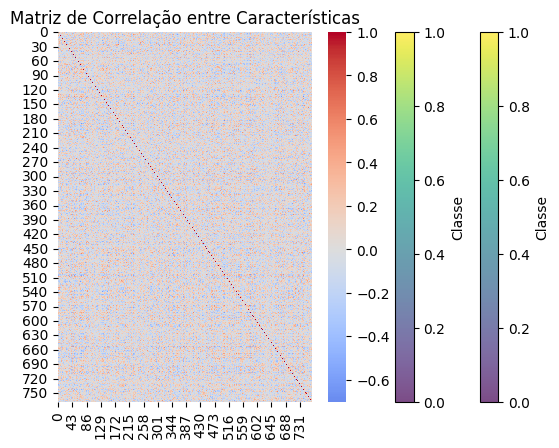

In [ ]:
# Métricas finais
print("\nMétricas Finais:")
output_dir="results"

#from evaluator import FeatureEvaluator
evaluator = FeatureEvaluator(features_train, labels_train,output_dir)
evaluator.generate_report()
evaluator.generate_pdf_report()

# Dados de teste

In [ ]:
features_test = factory.extract_and_save(extractor, X_test, y_test, 'test_features.npz')

In [ ]:
#features_train_reduced = data_processor.reduce_dimensionality(features_train)